In [1]:
# This notebook runs Bayesian Optimization on our dataset
!pip install botorch


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from botorch.models import FixedNoiseGP, SingleTaskGP
from gpytorch.kernels import ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from scipy.stats import norm
from botorch.acquisition.analytic import ExpectedImprovement
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import time

In [3]:
# Loading our data:
X = pickle.load(open('input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('input_output.pkl', 'rb'))['y']
y = np.reshape(y, (np.size(y), 1)) # for the GP
print("shape of y:", np.shape(y))

nb_inputs = X.shape[0]
print("No. of inputs:", nb_inputs)

nb_iterations = 50
print("No. of iterations: ", nb_iterations)

nb_runs = 1 # For now
print("No. of runs: ", nb_runs)

shape of X: (25877, 151)
shape of y: (25877, 1)
No. of inputs: 25877
No. of iterations:  50
No. of runs:  1


convert to torch tensors

In [4]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [5]:
X.size()

torch.Size([25877, 151])

In [6]:
y.size()

torch.Size([25877, 1])

In [7]:
X_unsqueezed = X.unsqueeze(1)

In [8]:
"""
BO run.

* nb_iterations: # of COFs to acquire = # of iterations in BO
* nb_COFs_initialization: # of COFs to acquire at random to initiate the GP and BO.
* which_acquisition: the acquisition function to use.
* store_explore_exploit_terms: True if you want to store (exploration contribution, exploitation contribution) to EI
"""
def bo_run(nb_iterations, nb_COFs_initialization, which_acquisition, verbose=False, store_explore_exploit_terms=False):
    assert nb_iterations > nb_COFs_initialization
    assert which_acquisition in ['max y_hat', 'EI', 'max sigma']

    # select initial COFs for training data randomly.
    # idea is to keep populating this ids_acquired and return it for analysis.
    ids_acquired = np.random.choice(np.arange((nb_inputs)), size=nb_COFs_initialization, replace=False)

    # keep track of exploration vs. exploitation terms ONLY for when using EI
    if which_acquisition == "EI" and store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.NaN, np.NaN) for i in range(nb_iterations)])
    else:
        explore_exploit_balance = [] # don't bother

    # initialize acquired y, since it requires normalization
    y_acquired = y[ids_acquired]
    # standardize outputs using *only currently acquired data*
    y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

    for i in range(nb_COFs_initialization, nb_iterations):
        print("iteration:", i, end="\r")
        # construct and fit GP model
        model = SingleTaskGP(X[ids_acquired, :], y_acquired)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # set up acquisition function
        if which_acquisition == "EI":
            acquisition_function = ExpectedImprovement(model, best_f=y_acquired.max().item())

            # if having memory problems, compute EI this way, in batches :)
#             batch_size = 35000 # need to do in batches to avoid mem issues
#             acquisition_values = torch.zeros((nb_COFs))
#             acquisition_values[:] = np.NaN # for safety
#             nb_batches = nb_COFs // batch_size
#             for ba in range(nb_batches+1):
#                 id_start = ba * batch_size
#                 id_end   = id_start + batch_size
#                 if id_end > nb_COFs:
#                     id_end = nb_COFs
#                 with torch.no_grad():
#                     acquisition_values[id_start:id_end] = acquisition_function.forward(X_unsqueezed[id_start:id_end])
#             assert acquisition_values.isnan().sum().item() == 0 # so that all are filled properly.
            with torch.no_grad(): # to avoid memory issues; we arent using the gradient...
                acquisition_values = acquisition_function.forward(X_unsqueezed) # runs out of memory
        elif which_acquisition == "max y_hat":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).mean.squeeze()
        elif which_acquisition == "max sigma":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).variance.squeeze()
        else:
            raise Exception("not a valid acquisition function")

        # select COF to acquire with maximal aquisition value, which is not in the acquired set already
        ids_sorted_by_aquisition = acquisition_values.argsort(descending=True)
        for id_max_aquisition_all in ids_sorted_by_aquisition:
            if not id_max_aquisition_all.item() in ids_acquired:
                id_max_aquisition = id_max_aquisition_all.item()
                break

        # acquire this COF
        ids_acquired = np.concatenate((ids_acquired, [id_max_aquisition]))
        assert np.size(ids_acquired) == i + 1

        # if EI, compute and store explore-exploit terms that contribute to EI separately.
        if which_acquisition == "EI" and store_explore_exploit_terms:
            # explore, exploit terms of EI. requires computing EI manually, essentially.
            y_pred = model.posterior(X_unsqueezed[id_max_aquisition]).mean.squeeze().detach().numpy()
            sigma_pred = np.sqrt(model.posterior(X_unsqueezed[id_max_aquisition]).variance.squeeze().detach().numpy())

            y_max = y_acquired.max().item()

            z = (y_pred - y_max) / sigma_pred
            explore_term = sigma_pred * norm.pdf(z)
            exploit_term = (y_pred - y_max) * norm.cdf(z)

            # check we computed it right... i.e. that it agrees with BO torch's EI.
            assert np.isclose(explore_term + exploit_term, acquisition_values[id_max_aquisition].item())

            explore_exploit_balance[i] = (explore_term, exploit_term)

        # update y aquired; start over to normalize properly
        y_acquired = y[ids_acquired] # start over to normalize y properly
        y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

        if verbose:
            print(i, "th acquired index: ", id_max_aquisition, " w/ y = ", y[id_max_aquisition].item())
            print("best y acquired:", y[ids_acquired].max().item())

    assert np.size(ids_acquired) == nb_iterations
    return ids_acquired, explore_exploit_balance

In [10]:
def bo(nb_iterations, nb_initialization, which_acquisition, verbose=False):
    assert nb_iterations > nb_COFs_initialization
    assert which_acquisition in ['max y_hat', 'EI', 'max sigma']

    # select initial inputs for training data randomly.
    # idea is to keep populating this ids_acquired and return it for analysis.
    ids_acquired = np.random.choice(np.arange((nb_inputs)), size=nb_initialization, replace=False)

    # initialize acquired y, since it requires normalization
    y_acquired = y[ids_acquired]
    # standardize outputs using *only currently acquired data*
    y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

    # Essentially, for the initial inputs that we take, we add the best one to the max_per_function_call nb_initialization times
    max_per_function_call = []
    for i in range(nb_initialization):
        max_per_function_call.append(y[ids_acquired].max().item())

    for i in range(nb_COFs_initialization, nb_iterations):
        print("iteration: ", i)
        # construct and fit GP model
        model = SingleTaskGP(X[ids_acquired, :], y_acquired)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # set up acquisition function
        if which_acquisition == "EI":
            acquisition_function = ExpectedImprovement(model, best_f=y_acquired.max().item())

            # if having memory problems, compute EI this way, in batches :)
#             batch_size = 35000 # need to do in batches to avoid mem issues
#             acquisition_values = torch.zeros((nb_COFs))
#             acquisition_values[:] = np.NaN # for safety
#             nb_batches = nb_COFs // batch_size
#             for ba in range(nb_batches+1):
#                 id_start = ba * batch_size
#                 id_end   = id_start + batch_size
#                 if id_end > nb_COFs:
#                     id_end = nb_COFs
#                 with torch.no_grad():
#                     acquisition_values[id_start:id_end] = acquisition_function.forward(X_unsqueezed[id_start:id_end])
#             assert acquisition_values.isnan().sum().item() == 0 # so that all are filled properly.
            with torch.no_grad(): # to avoid memory issues; we arent using the gradient...
                acquisition_values = acquisition_function.forward(X_unsqueezed) # runs out of memory
        elif which_acquisition == "max y_hat":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).mean.squeeze()
        elif which_acquisition == "max sigma":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).variance.squeeze()
        else:
            raise Exception("not a valid acquisition function")

        # select COF to acquire with maximal aquisition value, which is not in the acquired set already
        ids_sorted_by_aquisition = acquisition_values.argsort(descending=True)
        for id_max_aquisition_all in ids_sorted_by_aquisition:
            if not id_max_aquisition_all.item() in ids_acquired:
                id_max_aquisition = id_max_aquisition_all.item()
                break

        # acquire this COF
        ids_acquired = np.concatenate((ids_acquired, [id_max_aquisition]))
        assert np.size(ids_acquired) == i + 1

        # update y aquired; start over to normalize properly
        y_acquired = y[ids_acquired] # start over to normalize y properly
        y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

        # add the best input found to max_per_function_call:
        max_per_function_call.append(y[ids_acquired].max().item())

        if verbose:
            print("acquired index: ", id_max_aquisition, " w/ y = ", y[id_max_aquisition].item())
            print("best y acquired:", y[ids_acquired].max().item())

    assert np.size(ids_acquired) == nb_iterations
    return ids_acquired, max_per_function_call

In [11]:
# We're running BO and seeing what happens:
# We're running one singular BO:

nb_COFs_initialization = 10
which_acquisition = "EI"
ids_acquired, max_per_function_call = bo(nb_iterations, nb_COFs_initialization, which_acquisition, verbose=True)


iteration:  10
acquired index:  6352  w/ y =  2.836823825
best y acquired: 2.836823825
iteration:  11
acquired index:  2479  w/ y =  2.730679695
best y acquired: 2.836823825
iteration:  12
acquired index:  15708  w/ y =  2.708658912
best y acquired: 2.836823825
iteration:  13
acquired index:  6419  w/ y =  2.836835062
best y acquired: 2.836835062
iteration:  14
acquired index:  4158  w/ y =  2.836832801
best y acquired: 2.836835062
iteration:  15
acquired index:  3708  w/ y =  2.728890864
best y acquired: 2.836835062
iteration:  16
acquired index:  3218  w/ y =  2.730679695
best y acquired: 2.836835062
iteration:  17
acquired index:  14988  w/ y =  2.437178924
best y acquired: 2.836835062
iteration:  18
acquired index:  15240  w/ y =  2.522450908
best y acquired: 2.836835062
iteration:  19
acquired index:  18033  w/ y =  2.288428482
best y acquired: 2.836835062
iteration:  20
acquired index:  17148  w/ y =  3.389069145
best y acquired: 3.389069145
iteration:  21
acquired index:  16421 

[2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836823825, 2.836835062, 2.836835062, 2.836835062, 2.836835062, 2.836835062, 2.836835062, 2.836835062, 3.389069145, 3.389069145, 3.474331657, 3.474331657, 3.474331657, 3.474342227, 3.474342227, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199, 3.89563199]


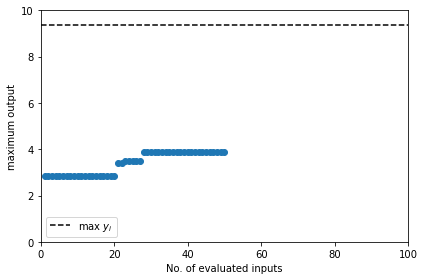

In [12]:
x_values = np.arange(1, len(max_per_function_call) + 1)

print(max_per_function_call)

plt.figure()
plt.scatter(x_values, max_per_function_call)
plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# We now have to run BO many times to find an average rate of optimization
# We will also measure the time taken for each of the optimization techniques to run!
import time


nb_iterations = 100
nb_COFs_initialization = 2
which_acquisition = "EI"
nb_runs = 50  # Number of runs of this we're doing!

max_per_function_call_arr = []
ids_acquired_arr = []
time_elapsed_per_run = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)

    start_time = time.time()

    ids_acquired, max_per_function_call = bo(nb_iterations, nb_COFs_initialization, which_acquisition, verbose=False)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Run # ",  run_no, " completed in ", elapsed_time, " seconds!")
    time_elapsed_per_run.append(elapsed_time)

    print("best_fitness for Run No. ", run_no, ": ", max_per_function_call[-1])
    max_per_function_call_arr.append(max_per_function_call)
    ids_acquired_arr.append(ids_acquired)

print(max_per_function_call_arr)
print(ids_acquired_arr)
print(time_elapsed_per_run)

# Dumping this data into a .pkl file:
with open('bo_results.pkl', 'wb') as file:
  pickle.dump({'max_per_function_call_arr': max_per_function_call_arr, 'ids_acquired_arr': ids_acquired_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

Run No.:  0
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iterat

iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iteration:  68
iteration:  69
iteration:  70
iteration:  71
iteration:  72
iteration:  73
iteration:  74
iteration:  75
iteration:  76
iteration:  77
iteration:  78
iteration:  79
iteration:  80
iteration:  81
iteration:  82
iteration:  83
iteration:  84
iteration:  85
iteration:  86
iteration:  87
iteration:  88
iteration:  89
iteration:  90
iteration:

iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iteration:  68
iteration:  69
iteration:  70
iteration:  71
iteration:  72
iteration:  73
iteration:  74
iteration:  75
iteration:  76
iteration:  77
iteration:  78
iteration:  79
iteration:  80
iteration:  81
iteration:  82
iteration:  83
iteration:  84
iteration:  85
iteration:  86
iteration:  87
iteration:  88
iteration:  89
iteration:  90
iteration:  91
iteration:  92
iteration:  93
iteration:  94
iteration:  95
iteration:  96
iteration:  97
iteration:  98
iteration:  99
Run #  10  completed in  203.15576934814453  seconds!
best_fitness for Run No.  10 :  8.751632419
Run No.:  11
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration: 

iteration:  70
iteration:  71
iteration:  72
iteration:  73
iteration:  74
iteration:  75
iteration:  76
iteration:  77
iteration:  78
iteration:  79
iteration:  80
iteration:  81
iteration:  82
iteration:  83
iteration:  84
iteration:  85
iteration:  86
iteration:  87
iteration:  88
iteration:  89
iteration:  90
iteration:  91
iteration:  92
iteration:  93
iteration:  94
iteration:  95
iteration:  96
iteration:  97
iteration:  98
iteration:  99
Run #  15  completed in  186.41124033927917  seconds!
best_fitness for Run No.  15 :  1.004168582
Run No.:  16
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  

iteration:  92
iteration:  93
iteration:  94
iteration:  95
iteration:  96
iteration:  97
iteration:  98
iteration:  99
Run #  20  completed in  197.71456837654114  seconds!
best_fitness for Run No.  20 :  5.076869912
Run No.:  21
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  

iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iteration:  68
iteration:  69
iteration:  70
iteration:  71
iteration:  72
iteration:  73
iteration:  74
iteration:  75
iteration:

iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iteration:  68
iteration:  69
iteration:  70
iteration:  71
iteration:  72
iteration:  73
iteration:  74
iteration:  75
iteration:  76
iteration:  77
iteration:  78
iteration:  79
iteration:  80
iteration:  81
iteration:  82
iteration:  83
iteration:  84
iteration:  85
iteration:  86
iteration:  87
iteration:  88
iteration:  89
iteration:  90
iteration:  91
iteration:  92
iteration:  93
iteration:  94
iteration:  95
iteration:  96
iteration:  97
iteration:

iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iteration:  68
iteration:  69
iteration:  70
iteration:  71
iteration:  72
iteration:  73
iteration:  74
iteration:  75
iteration:  76
iteration:  77
iteration:  78
iteration:  79
iteration:  80
iteration:  81
iteration:  82
iteration:  83
iteration:  84
iteration:  85
iteration:  86
iteration:  87
iteration:  88
iteration:  89
iteration:  90
iteration:  91
iteration:  92
iteration:  93
iteration:  94
iteration:  95
iteration:  96
iteration:  97
iteration:  98
iteration:  99
Run #  36  completed in  222.0438187122345  seconds!
best_fitness for Run No.  36 :  5.509513494
Run No.:  37
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  1

iteration:  76
iteration:  77
iteration:  78
iteration:  79
iteration:  80
iteration:  81
iteration:  82
iteration:  83
iteration:  84
iteration:  85
iteration:  86
iteration:  87
iteration:  88
iteration:  89
iteration:  90
iteration:  91
iteration:  92
iteration:  93
iteration:  94
iteration:  95
iteration:  96
iteration:  97
iteration:  98
iteration:  99
Run #  41  completed in  181.69045162200928  seconds!
best_fitness for Run No.  41 :  0.727180829
Run No.:  42
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  

iteration:  98
iteration:  99
Run #  46  completed in  180.56366968154907  seconds!
best_fitness for Run No.  46 :  0.535488147
Run No.:  47
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  

In [14]:
# Dumping this data into a .pkl file:
with open('bo_results.pkl', 'wb') as file:
  pickle.dump({'max_per_function_call_arr': max_per_function_call_arr, 'ids_acquired_arr': ids_acquired_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(nb_runs):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(max_per_function_call_arr[j]) ): #only if max_per_function_call_arr[j] has ith iteration!
              y_maxes.append(max_per_function_call_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [3.063389122, 4.156399939, 0.720559008, 3.518540556, 3.227043247, 6.589508562, 1.315834979, 3.86937371, 4.267187623, 3.797422844, 3.64083087, 3.912508441, 4.204993743, 6.237292096, 8.114828365, 4.42266986, 1.391680639, 3.321868869, 3.294253447, 4.786863746, 6.576700296, 2.338506113, 2.879615172, 2.84951143, 2.471981872, 4.220139993, 6.183734783, 7.008421897, 4.269682958, 4.496194097, 3.577902957, 3.490982915, 0.67823605, 0.598061412, 4.489595362, 2.30690692, 2.375171313, 6.300649253, 3.353004959, 3.620244832, 0.642777515, 3.474303089, 5.721445482, 3.200858557, 3.415592296, 4.495289718, 6.232734876, 3.890345113, 6.686438756, 1.141334023]
y_max_mu[i]:  3.8167882735000007
y_maxes < y_max_mu[i]:  [ True False  True  True  True False  True False False  True  True False
 False False False False  True  True  True False False  True  True  True
  True False False False False False  True  True  True  True False  True
  True False  True  True  True  True False  True  T

In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


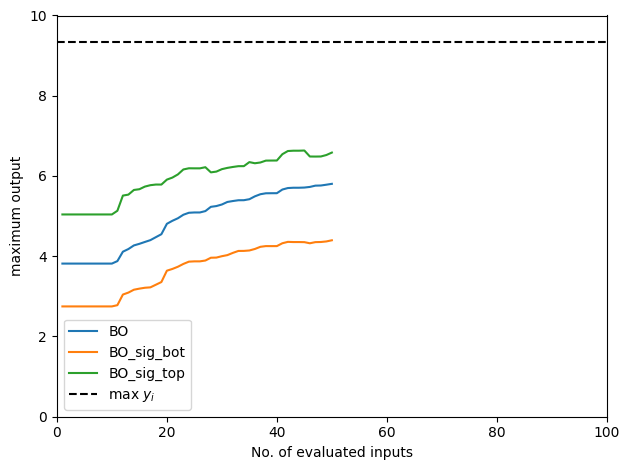

In [ ]:
x_values = np.arange(1, nb_runs + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="BO", clip_on=False)
plt.plot(x_values, np_y_max_mu - np_y_max_sig_bot, label="BO_sig_bot")
plt.plot(x_values, np_y_max_mu + np_y_max_sig_top, label="BO_sig_top")
plt.fill_between(nb_runs, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.show()

must run with `which_acquisition` equal to all three below.

In [ ]:
which_acquisition = "EI"
# which_acquisition = "max y_hat"
# which_acquisition = "max sigma"
nb_COFs_initializations = {"EI": [5, 10, 15, 20, 25],
                           "max y_hat": [10],
                           "max sigma": [10]}

for nb_COFs_initialization in nb_COFs_initializations[which_acquisition]:
    print("# COFs in initialization:", nb_COFs_initialization)
    # store results here.
    bo_res = dict()
    bo_res['ids_acquired']            = []
    bo_res['explore_exploit_balance'] = []

    if nb_COFs_initialization == 10 and which_acquisition == 'EI':
        store_explore_exploit_terms = True
    else:
        store_explore_exploit_terms = False

    for r in range(nb_runs):
        print("\nRUN", r)
        t0 = time.time()

        ids_acquired, explore_exploit_balance = bo_run(nb_iterations, nb_COFs_initialization, which_acquisition, store_explore_exploit_terms=store_explore_exploit_terms)

        # store results from this run.
        bo_res['ids_acquired'].append(ids_acquired)
        bo_res['explore_exploit_balance'].append(explore_exploit_balance)

        print("took time t = ", (time.time() - t0) / 60, "min\n")

    # save results from all runs
    with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'wb') as file:
        pickle.dump(bo_res, file)

with open('bo_results_nb_COF_initializations.pkl', 'wb') as file:
    pickle.dump(nb_COFs_initializations, file)

# COFs in initialization: 10

RUN 0
took time t =  2.491740079720815 min


RUN 1
took time t =  2.3598769982655843 min


RUN 2
took time t =  2.2923808137575787 min


RUN 3
took time t =  2.4538424968719483 min


RUN 4
took time t =  2.2930290619532268 min


RUN 5
took time t =  2.452386287848155 min


RUN 6
took time t =  2.5364050308863324 min


RUN 7
took time t =  2.28095672527949 min


RUN 8
took time t =  2.3892273267110187 min


RUN 9
took time t =  2.3227869510650634 min


RUN 10
took time t =  2.3925676941871643 min


RUN 11
took time t =  2.3349881052970884 min


RUN 12
took time t =  2.339087728659312 min


RUN 13
took time t =  2.480728538831075 min


RUN 14
took time t =  2.342625153064728 min


RUN 15
took time t =  2.28629891872406 min


RUN 16
took time t =  2.565360959370931 min


RUN 17


/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/lin

took time t =  2.4627824306488035 min


RUN 18
took time t =  2.409364386399587 min


RUN 19


/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/santanu/anaconda3/envs/sage/lib/python3.8/site-packages/lin

took time t =  2.6117578665415446 min


RUN 20
took time t =  2.315704945723216 min


RUN 21
took time t =  2.382988409201304 min


RUN 22
took time t =  2.2967713793118794 min


RUN 23
took time t =  2.311958742141724 min


RUN 24
took time t =  2.488028864065806 min


RUN 25
took time t =  2.3035463213920595 min


RUN 26
took time t =  2.3117849826812744 min


RUN 27
took time t =  2.366830825805664 min


RUN 28
took time t =  2.278993240992228 min


RUN 29
took time t =  2.1843421936035154 min


RUN 30
took time t =  2.409311560789744 min


RUN 31
took time t =  2.3542076071103413 min


RUN 32
took time t =  2.131477439403534 min


RUN 33
took time t =  2.244883648554484 min


RUN 34
took time t =  2.3656041304270428 min


RUN 35
took time t =  2.3882257024447124 min


RUN 36
took time t =  2.559925897916158 min


RUN 37
took time t =  2.4093440731366473 min


RUN 38
took time t =  2.414399512608846 min


RUN 39
took time t =  2.225052313009898 min


RUN 40
took time t =  2.20104854